### Make sure to create a new virtual environment and installed reqirements.txt

### (Step-1) Importing Required Libraries 

In [1]:
import os
import cv2
import keras
import random
import skimage
import warnings
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from IPython.display import Image
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.pyplot import * 
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.layers import Input,Lambda,Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D,Dropout,concatenate,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import save_img
warnings.filterwarnings('ignore')

Using TensorFlow backend.


#### Define seed function to set seed value to generate random numbers (RNG or Random number generator)

### Why do we need the seed function?

##### Imagine you trained a deep learning model on some data-set. 
##### A few days later, you want to reproduce the same experiment, but if you were not careful, you may never be able to reproduce the same experiment exactly even if you used the same architecture, the same dataset, and trained on the same machine!
##### The underlying reason for this behavior is that deep learning training processes are stochastic in nature. 
##### This randomness is often acceptable and indeed desirable.
##### Thus we will go over the steps necessary to ensure you are able to reproduce a training experiment in Tensorflow/PyTorch at least with the same version and same platform (OS etc.)

In [2]:
seed = 42
random.seed = seed
np.random.seed = seed

### Check libraries versions

In [3]:
print("keras version:",keras.__version__)
print("tensorflow version:",tf.__version__)
print("skimage version:",skimage.__version__)

keras version: 2.2.5
tensorflow version: 1.15.0
skimage version: 0.15.0


### Initialize Image Size

In [4]:
width = 224
height = 224
channels = 3

#### Give path to our data for training and I look and preprocessed only few data

#### Download here --> https://drive.google.com/drive/folders/1MeKVNywo2hlyTdlNMG-KvG00soqwQaJm?usp=sharing 

In [5]:
train='/home/metagogy/Downloads/CelebAMask-HQ/data/C_685/'
mask="/home/metagogy/Downloads/CelebAMask-HQ/data/C_685-anno_eyes_and_lips/"

### (Step-2) Resizing our images and masks in the shape of 224 x 224 

In [6]:
train_ids = list(int(s.split(".")[0]) for s in list(next(os.walk(train))[2]))
X_train = np.zeros((len(train_ids), height, width, channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), height, width, 1))

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(train+str(id_)+'.jpg')[:,:,:channels]
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    X_train[n] = img
    im_gray = cv2.imread(mask+"eyes_and_lips_"+str(id_)+".png", cv2.IMREAD_GRAYSCALE)
    if im_gray is None:
        continue
    im_gray = resize(im_gray, (height, width), mode='constant', preserve_range=True)
    Y_train[n] = np.expand_dims(im_gray,axis=2)

100%|██████████| 1071/1071 [04:55<00:00,  3.62it/s]


### Defining IoU Metric

##### IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks.
##### We use this metric for semantic segmentation

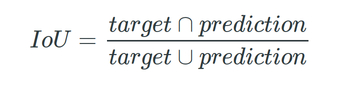

In [1]:
Image(filename='/home/metagogy/Downloads/img/1.jpg')

##### The mean average precision at different intersection over union (IoU) thresholds metric in Keras. 
##### TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so we need to implement this by ourselves. 
##### However, in a first stage, we used the Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. 
##### So it is more similar to precision than accuracy. 
##### The only difference is the denominator, where you have the total number of positives instead of only the positives that the method finds. 
##### So the Dice score is also penalizing for the positives that your algorithm/method could not find.
##### Now, we are going to try to define a IoU metric

In [7]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### (Step-3) Model Building

#### The architecture used is the so-called U-Net, which is very common for image segmentation problems such as this.

In [8]:
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

##### Input() is used to instantiate a Keras tensor

inputs = tf.keras.layers.Input((height, width, channels))

##### Block 1: Conv + batchnormalization + activation

convolution1 = tf.keras.layers.Conv2D(32, 3, strides = (2,2), padding='same', kernel_initializer=init)(inputs)
batchnormalization1 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution1)
activation1 = tf.keras.layers.ReLU()(batchnormalization1)

##### Block 2: Conv + batchnormalization + activation
        
convolution2 = tf.keras.layers.Conv2D(64, 3, strides = (2,2), padding='same', kernel_initializer=init)(activation1)
batchnormalization2 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution2)
activation2 = tf.keras.layers.ReLU()(batchnormalization2)

##### Block 3: Conv + batchnormalization + activation
        
convolution3 = tf.keras.layers.Conv2D(128 , 3, strides = (2,2), padding='same', kernel_initializer=init)(activation2)
batchnormalization3 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution3)
activation3 = tf.keras.layers.ReLU()(batchnormalization3)

##### Block 4: Conv + batchnormalization + activation + dropout
        
convolution4 = tf.keras.layers.Conv2D(256, 3, strides = (2,2), padding='same', kernel_initializer=init)(activation3)
batchnormalization4 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution4)
activation4 = tf.keras.layers.ReLU()(batchnormalization4)
drop4 = tf.keras.layers.Dropout(0.5)(activation4)

##### Block 5: Conv + batchnormalization + activation + Concatenate

convolution5 = tf.keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = init)(tf.keras.layers.UpSampling2D(size=(2, 2))(drop4))
batchnormalization5 =tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution5)
activation5 = tf.keras.layers.ReLU()(batchnormalization5)

merge5 = concatenate([activation3, activation5], axis=3)

##### Block 6: Conv + batchnormalization + activation

convolution6 = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer=init)(merge5)
batchnormalization6 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution6)
activation6 = tf.keras.layers.ReLU()(batchnormalization6)

##### Block 7: Conv + batchnormalization + activation + Concatenate

convolution7 = tf.keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = init) (tf.keras.layers.UpSampling2D(size=(2, 2))(activation6))
batchnormalization7 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution7)
activation7 = tf.keras.layers.ReLU()(batchnormalization7)

merge6 = concatenate([activation2, activation7], axis=3)

##### Block 8: Conv + batchnormalization + activation

convolution8 = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer=init)(merge6)
batchnormalization8 =tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution8)
activation8 = tf.keras.layers.ReLU()(batchnormalization8)

##### Block 9: Conv + batchnormalization + activation + Concatenate

convolution9 = tf.keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = init) (tf.keras.layers.UpSampling2D(size=(2, 2))(activation8))
batchnormalization9 = tf.keras.layers.BatchNormalization(momentum = 0.8)(convolution9)
activation9 = tf.keras.layers.ReLU()(batchnormalization9)

merge7 = concatenate([activation1, activation9], axis=3)

up11 = tf.keras.layers.UpSampling2D(size=(2,2))(merge7)

#### Output Layer: Logistic Unit

convolution10 = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid', padding='same')(up11)

model = tf.keras.Model(inputs=[inputs], outputs=[convolution10])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### (Step-4) Compiling model using loss and optimizer

##### Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
##### learning_rate: A Tensor, floating point value, or a schedule.
##### Keras provides the following cross-entropy loss functions: binary, categorical, sparse categorical cross-entropy loss functions.

In [9]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
______________________________________________________________________

### (Step-5) Training set up
##### A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.
##### Some observations on the functions used:
##### keras.callbacks.EarlyStopping() : Stop training when a monitored quantity has stopped improving. 
##### Parameters:
- **patience**: number of epochs with no improvement after which training will be stopped
- **verbose**: verbosity mode
##### keras.callbacks.ModelCheckpoint(): Save the model after every epoch. 
##### Parameters:
- **filepath**: string, path to save the model file
- **save_best_only** if save_best_only = True, the latest best model according to the quantity monitored will not be overwritten.

In [ ]:
X_train = X_train/255.0
Y_train = Y_train/255.0

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/home/metagogy/Downloads/CelebAMask-HQ/model.h5', 
                               verbose=1, save_best_only=True)

##### model.fit(): 
##### Parameters:
 - **validation_split**: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.
 - **batch_size**: Integer or None. Number of samples per gradient update. If unspecified, it will default to 32.

In [10]:
results = model.fit(X_train, Y_train, validation_split=len(train_ids) / len(X_train) * 0.1, 
                    batch_size=32, epochs=5, callbacks=[earlystopper, checkpointer])

Train on 963 samples, validate on 108 samples
Epoch 1/5
960/963 [============================>.] - ETA: 0s - loss: 0.1371 - mean_iou: 0.4638
Epoch 00001: val_loss improved from inf to 0.05474, saving model to /home/metagogy/Downloads/CelebAMask-HQ/model.h5
963/963 [==============================] - 254s 264ms/sample - loss: 0.1369 - mean_iou: 0.4642 - val_loss: 0.0547 - val_mean_iou: 0.4913
Epoch 2/5
960/963 [============================>.] - ETA: 0s - loss: 0.0418 - mean_iou: 0.4954
Epoch 00002: val_loss improved from 0.05474 to 0.04028, saving model to /home/metagogy/Downloads/CelebAMask-HQ/model.h5
963/963 [==============================] - 254s 264ms/sample - loss: 0.0418 - mean_iou: 0.4955 - val_loss: 0.0403 - val_mean_iou: 0.5053
Epoch 3/5
960/963 [============================>.] - ETA: 0s - loss: 0.0311 - mean_iou: 0.5202
Epoch 00003: val_loss improved from 0.04028 to 0.02880, saving model to /home/metagogy/Downloads/CelebAMask-HQ/model.h5
963/963 [==============================

In [11]:
print("Model successfully trained and saved.......")

Model successfully trained and saved.......


### Visualizing accuracy and loss 

dict_keys(['loss', 'mean_iou', 'val_loss', 'val_mean_iou'])


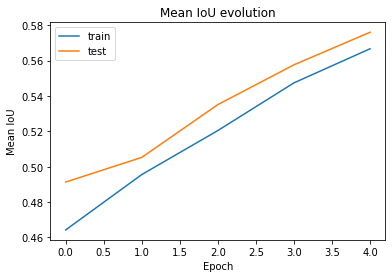

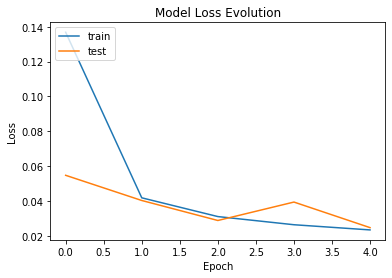

In [13]:
history = results 
print(history.history.keys())

# summarize history for accuracy
fig_accuracy = plt.figure(1)
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Mean IoU evolution')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig_loss = plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### (Step-6) Loading trained model weights

In [14]:
model = load_model('/home/metagogy/Downloads/CelebAMask-HQ/model.h5', custom_objects={'mean_iou': mean_iou})
preds = model.predict(X_train[:10], verbose=1)
# Threshold predictions
pred = (preds > 0.5).astype(np.uint8)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
10/10 [==============================] - 1s 102ms/sample


### (Step-7) Making predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


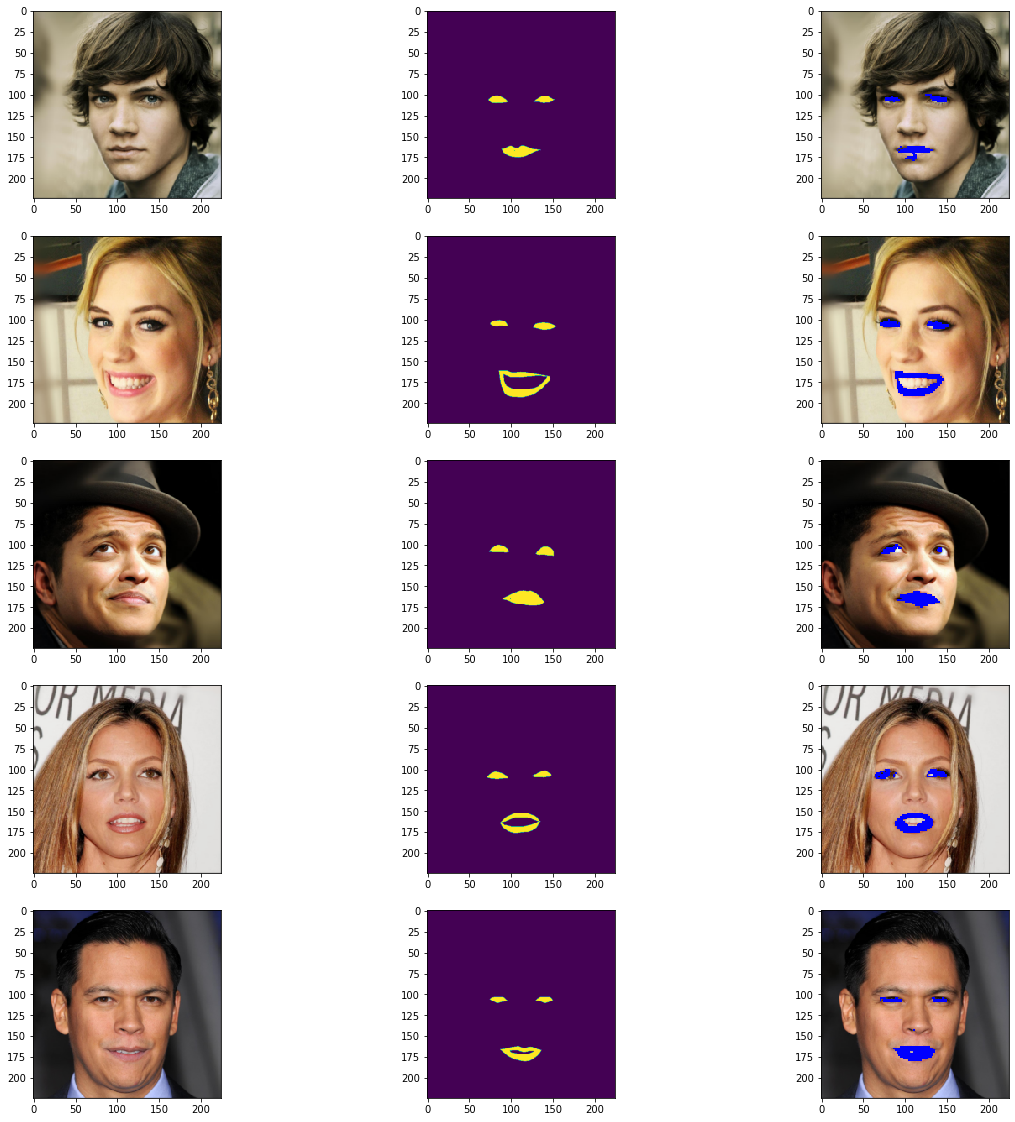

In [28]:
X=deepcopy(X_train)
Y=deepcopy(Y_train)

fig=plt.figure(figsize=(20, 20))

for img in range(0,5):
    fig.add_subplot(5,3, 3*img+1)
    img1=deepcopy(X[img][:,:,:])
    imshow(img1)
    fig.add_subplot(5,3, 3*img+2)
    imshow(np.squeeze(Y[img]))
    fig.add_subplot(5,3, 3*img+3)
    img2=deepcopy(np.squeeze(pred[img])[:,:])
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):
            if(img2[i,j]!=0):
                img1[i,j,:]=[0,0,255]
    imshow(img1)
    cv2.imwrite("Eyes-and-lips-segmentation.jpg", img2)
plt.show()